## following huggingface notebook [advanced RAG](https://huggingface.co/learn/cookbook/en/advanced_rag)

In [1]:
import pandas as pd
from typing import Optional, List, Tuple

pd.set_option(
    "display.max_colwidth", None
)

### Load your knowledge base

In [2]:
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("doc/logan_donovan_complete_guide_to_chess.pdf")
pages = loader.load_and_split() # it splits by page number

In [3]:
len(pages)

140

In [4]:
type(pages[0])

langchain_core.documents.base.Document

In [5]:
for i in range(len(pages)):
    pages[i].page_content = pages[i].page_content.replace("\t", " ")

In [6]:
pages[0].page_content

'The Complete Guide to Chess\nM aster: Chess Tactics, Chess Openings and Chess Strategies\nLogan Donovan'

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
MARKDOWN_SEPARATORS = [
    "\n\n",
    "\n",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=100,
    add_start_index=True,
    strip_whitespace=True,
    separators=MARKDOWN_SEPARATORS,
)

chess_book_processed = []
for doc in pages:
    chess_book_processed += text_splitter.split_documents([doc])

In [8]:
len(chess_book_processed)

254

In [9]:
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(chess_book_processed)]

  0%|          | 0/254 [00:00<?, ?it/s]

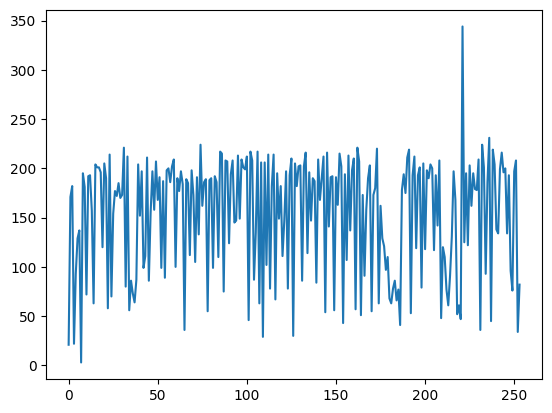

In [10]:
import matplotlib.pyplot as plt
plt.plot(lengths)

In [11]:
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import warnings
warnings.filterwarnings("ignore")
EMBEDDING_MODEL_NAME = "thenlper/gte-small"
embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # Set True for cosine similarity, check if we can use euclidean l2
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    chess_book_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
user_query = "who is the author of the book complete guide to chess?"
query_vector = embedding_model.embed_query(user_query)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
retrieved_docs_test = KNOWLEDGE_VECTOR_DATABASE.similarity_search_with_score(query=user_query, k=1)
retrieved_docs_test

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[(Document(page_content='employed chess tactics and strategies.\nIt is in my dear aspirations that this book in your possession helps you elevate not\nonly your skillfulness in chess, but your intellectual grace as well.\nSincerely,\nLogan Donovan\nP.S. Don’t forget to grab your free bonus at the end of the book', metadata={'source': 'doc/logan_donovan_complete_guide_to_chess.pdf', 'page': 9, 'start_index': 0}),
  0.2046861)]

In [15]:
len(retrieved_docs_test),retrieved_docs_test[0].page_content

(1,
 'employed chess tactics and strategies.\nIt is in my dear aspirations that this book in your possession helps you elevate not\nonly your skillfulness in chess, but your intellectual grace as well.\nSincerely,\nLogan Donovan\nP.S. Don’t forget to grab your free bonus at the end of the book')

In [18]:
retrieved_docs_test = KNOWLEDGE_VECTOR_DATABASE.similarity_search_with_score(query=user_query, k=5)
retrieved_docs_test

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[(Document(page_content='employed chess tactics and strategies.\nIt is in my dear aspirations that this book in your possession helps you elevate not\nonly your skillfulness in chess, but your intellectual grace as well.\nSincerely,\nLogan Donovan\nP.S. Don’t forget to grab your free bonus at the end of the book', metadata={'source': 'doc/logan_donovan_complete_guide_to_chess.pdf', 'page': 9, 'start_index': 0}),
  0.2046861),
 (Document(page_content='Conclusion\nI hope that you are excited to practice the different openings and tactics mentioned\nin this book. As you can clearly see, Chess involves more planning than cleverness\nto play and you should be quick enough to read your opponent’s moves and play\nyour move accordingly before the time runs out.\nIn addition, your newfound skills will be sure to attract a larger volume of players to\nsit across from you. Believe it or not, the game of chess entices excitement and\nworth in people from all different backgrounds. Who wouldn’t enj

In [16]:
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5) # k number of documents
len(retrieved_docs), retrieved_docs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(5,
 [Document(page_content='employed chess tactics and strategies.\nIt is in my dear aspirations that this book in your possession helps you elevate not\nonly your skillfulness in chess, but your intellectual grace as well.\nSincerely,\nLogan Donovan\nP.S. Don’t forget to grab your free bonus at the end of the book', metadata={'source': 'doc/logan_donovan_complete_guide_to_chess.pdf', 'page': 9, 'start_index': 0}),
  Document(page_content='Conclusion\nI hope that you are excited to practice the different openings and tactics mentioned\nin this book. As you can clearly see, Chess involves more planning than cleverness\nto play and you should be quick enough to read your opponent’s moves and play\nyour move accordingly before the time runs out.\nIn addition, your newfound skills will be sure to attract a larger volume of players to\nsit across from you. Believe it or not, the game of chess entices excitement and\nworth in people from all different backgrounds. Who wouldn’t enjoy pitting

In [21]:
# this prints only the page content of the top document
# needs more research on the returned similarity score
print(f"\nStarting retrieval for {user_query=}...")

print(
    "\n==================================Top document=================================="
)
print("[INFO] Document 1")
print(f"[INFO Similarity Score {retrieved_docs_test[0][1]}]")
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='who is the author of the book complete guide to chess?'...

==================================Top document==================================
[INFO] Document 1
[INFO Similarity Score 0.20468610525131226]
employed chess tactics and strategies.
It is in my dear aspirations that this book in your possession helps you elevate not
only your skillfulness in chess, but your intellectual grace as well.
Sincerely,
Logan Donovan
P.S. Don’t forget to grab your free bonus at the end of the book
==================================Metadata==================================
{'source': 'doc/logan_donovan_complete_guide_to_chess.pdf', 'page': 9, 'start_index': 0}


## LLM

In [15]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
load_dotenv("../finetune/.env")
login(os.getenv("hf_token"))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/s448780/.cache/huggingface/token
Login successful


In [16]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "mistralai/Mistral-7B-v0.1"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## prompt

In [17]:
prompt_template = """<s>[INST] 
Instruction: Always answer the question even if the context isn't useful. 
Write a response that appropriately completes the request. Do not say anything unnecessary.
Here is context to help -
{context}

### QUESTION:
{question} 

[/INST]
 """

In [18]:
# prompt_in_chat_format = [
#     {
#         "role": "system",
#         "content": """Always answer the question even if the context isn't useful. Based on provided context and your knowledge, answer the question concisely.""",
#     },
#     {
#         "role": "user",
#         "content": """Context:
# {context}
# ---
# Now here is the question you need to answer.

# Question: {question}""",
#     },
# ]
# RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
#     prompt_in_chat_format, tokenize=False, add_generation_prompt=True
# )
# print(RAG_PROMPT_TEMPLATE)

In [19]:
# prompt_template+tokenizer.eos_token

In [20]:
from langchain.prompts import PromptTemplate
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)
prompt

PromptTemplate(input_variables=['context', 'question'], template="<s>[INST] \nInstruction: Always answer the question even if the context isn't useful. \nWrite a response that appropriately completes the request. Do not say anything unnecessary.\nHere is context to help -\n{context}\n\n### QUESTION:\n{question} \n\n[/INST]\n ")

In [21]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)
context

'\nExtracted documents:\nDocument 0:::\nemployed chess tactics and strategies.\nIt is in my dear aspirations that this book in your possession helps you elevate not\nonly your skillfulness in chess, but your intellectual grace as well.\nSincerely,\nLogan Donovan\nP.S. Don’t forget to grab your free bonus at the end of the bookDocument 1:::\nConclusion\nI hope that you are excited to practice the different openings and tactics mentioned\nin this book. As you can clearly see, Chess involves more planning than cleverness\nto play and you should be quick enough to read your opponent’s moves and play\nyour move accordingly before the time runs out.\nIn addition, your newfound skills will be sure to attract a larger volume of players to\nsit across from you. Believe it or not, the game of chess entices excitement and\nworth in people from all different backgrounds. Who wouldn’t enjoy pitting their\ncreative thinking against another in a friendly, competitive game? There is a reason\nthat che

In [22]:
# final_prompt = RAG_PROMPT_TEMPLATE.format(
#     question=user_query, context=context
# )

In [23]:
target = prompt.format(question=user_query, context=context)
target

"<s>[INST] \nInstruction: Always answer the question even if the context isn't useful. \nWrite a response that appropriately completes the request. Do not say anything unnecessary.\nHere is context to help -\n\nExtracted documents:\nDocument 0:::\nemployed chess tactics and strategies.\nIt is in my dear aspirations that this book in your possession helps you elevate not\nonly your skillfulness in chess, but your intellectual grace as well.\nSincerely,\nLogan Donovan\nP.S. Don’t forget to grab your free bonus at the end of the bookDocument 1:::\nConclusion\nI hope that you are excited to practice the different openings and tactics mentioned\nin this book. As you can clearly see, Chess involves more planning than cleverness\nto play and you should be quick enough to read your opponent’s moves and play\nyour move accordingly before the time runs out.\nIn addition, your newfound skills will be sure to attract a larger volume of players to\nsit across from you. Believe it or not, the game o

In [24]:
answer = READER_LLM(target)[0]["generated_text"]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [25]:
print(answer.strip())

[ANSWER]

Answer: Logan Donovan

[/ANSWER]


In [26]:
general_knowledge = prompt.format(question="What's the capital of Australia", context="")
gk_answer = READER_LLM(general_knowledge)[0]["generated_text"]
print(gk_answer.strip())

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INP] 
Input: What's the capital of Australia 

[/INP]
 
[OUT] 
Output: Canberra

[/OUT]


## PEFT

In [32]:
from peft import PeftConfig, PeftModel

In [33]:
lora_model_name = "adnaan525/opensi_mistral_3tasks"
adapter_config = PeftConfig.from_pretrained(lora_model_name)

In [34]:
model_with_lora = PeftModel.from_pretrained(model, lora_model_name)
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

In [46]:
lora_LLM = pipeline(
    model=model_with_lora,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'JambaForCausalLM', 'JetMoeForCausalLM', 'LlamaForCausalLM', 'MambaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalL

In [47]:
prompt_template = """<s>[INST] 
Instruction: Always answer the question even if the context isn't useful. 
Write a response that appropriately completes the request. Do not say anything unnecessary.
Here is context to help -
{context}

### QUESTION:
{question} 

[/INST]
 """

In [48]:
from langchain.prompts import PromptTemplate
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)
prompt

PromptTemplate(input_variables=['context', 'question'], template="<s>[INST] \nInstruction: Always answer the question even if the context isn't useful. \nWrite a response that appropriately completes the request. Do not say anything unnecessary.\nHere is context to help -\n{context}\n\n### QUESTION:\n{question} \n\n[/INST]\n ")

In [49]:
retrieved_docs_text = [doc.page_content for doc in retrieved_docs]
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)
context

'\nExtracted documents:\nDocument 0:::\nemployed chess tactics and strategies.\nIt is in my dear aspirations that this book in your possession helps you elevate not\nonly your skillfulness in chess, but your intellectual grace as well.\nSincerely,\nLogan Donovan\nP.S. Don’t forget to grab your free bonus at the end of the bookDocument 1:::\nConclusion\nI hope that you are excited to practice the different openings and tactics mentioned\nin this book. As you can clearly see, Chess involves more planning than cleverness\nto play and you should be quick enough to read your opponent’s moves and play\nyour move accordingly before the time runs out.\nIn addition, your newfound skills will be sure to attract a larger volume of players to\nsit across from you. Believe it or not, the game of chess entices excitement and\nworth in people from all different backgrounds. Who wouldn’t enjoy pitting their\ncreative thinking against another in a friendly, competitive game? There is a reason\nthat che

In [50]:
target = prompt.format(question=user_query, context=context)
target

"<s>[INST] \nInstruction: Always answer the question even if the context isn't useful. \nWrite a response that appropriately completes the request. Do not say anything unnecessary.\nHere is context to help -\n\nExtracted documents:\nDocument 0:::\nemployed chess tactics and strategies.\nIt is in my dear aspirations that this book in your possession helps you elevate not\nonly your skillfulness in chess, but your intellectual grace as well.\nSincerely,\nLogan Donovan\nP.S. Don’t forget to grab your free bonus at the end of the bookDocument 1:::\nConclusion\nI hope that you are excited to practice the different openings and tactics mentioned\nin this book. As you can clearly see, Chess involves more planning than cleverness\nto play and you should be quick enough to read your opponent’s moves and play\nyour move accordingly before the time runs out.\nIn addition, your newfound skills will be sure to attract a larger volume of players to\nsit across from you. Believe it or not, the game o

In [51]:
answer = lora_LLM(target)[0]["generated_text"]
print(answer.strip())

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


## Game Analysis

**Pair 1: White: e4, Black: e5**
- **White:** Opens with the King's Pawn, aiming to control the center and prepare for rapid development.
- **Black:** Mirrors White's move, also controlling the center and preparing for rapid development.

**Pair 2: White: Nf3, Black: Nc6**
- **White:** Develops the knight to attack the e5 pawn and prepares for kingside castling.
- **Black:** Defends the e5 pawn and develops a piece, eyeing the d4 square.

**Pair 3: White: Bb5, Black: a6**
- **White:** Pins the knight on c6 to the queen, exerting pressure on Black's position.
- **Black:** Forces the bishop to make a decision, potentially preparing to drive it away.

**Pair 4: White: Ba4, Black: Nf6**
- **White:** Retreats the bishop to maintain the pin on the knight.
- **Black:** Develops another piece, attacking the e4 pawn and preparing to castle.

**Pair 5: White: O-O, Black: Be7**
- **White:** Castles to safeguard the king and connect the rooks.
- **Black:** Prepares to castle and 

In [52]:
general_knowledge = prompt.format(question="What's the capital of Australia", context="")
gk_answer = lora_LLM(general_knowledge)[0]["generated_text"]
print(gk_answer.strip())

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


## Answer:
The capital of Australia is Canberra. It was chosen as the capital in 1908 and officially became the capital in 1927. The city is located in the Australian Capital Territory, which is a federal territory within Australia.


In [53]:
general_knowledge = prompt.format(question="Analyse what's the capital of Australia", context="")
gk_answer = lora_LLM(general_knowledge)[0]["generated_text"]
print(gk_answer.strip())

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


## ANALYSIS:
- **Capital of Australia**: The capital city of Australia is Canberra, located in the Australian Capital Territory (ACT). It was chosen as the capital in 1908 and became the seat of government in 1927.

**Rationale:**
- **Canberra**: The choice of Canberra as the capital was influenced by several factors, including its central location between Sydney and Melbourne, the availability of suitable land for development, and the desire to create a new national identity distinct from the colonial past.
- **Australian Capital Territory**: The ACT was created specifically for the purpose of establishing Canberra as the nation's capital. It is governed separately from the states and territories and has its own legislative assembly and chief minister.

**Conclusion**: Canberra is the capital of Australia due to its strategic location, suitability for development, and the establishment of the Australian Capital Territory.
